In [1]:
# Importing packages
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
from scipy.optimize import minimize, basinhopping

# Importing Pauli matrices
from pauli_matrices.pauli_matrices import I, X, Y, Z

# Importing figure properties
from figure_test_files.figure_properties import *

# Importing functions
from Bell_operator.Bell_operator import get_Bell_terms
from Bell_operator.coefficients import get_coefficients
from classical_optimization.classical_optimization import classical_optimization
from correlation_matrix.correlation_matrix import get_correlation_matrix

# Defining saving directory
save_dir = '../data/figures/'


In [2]:
def calc_classical_bound(theta, H, N, m, basis, extra_Z_gate):

    # Obtaining the general correlation matrix
    M = get_correlation_matrix(theta, N, m, basis=basis, extra_Z_gate=extra_Z_gate)

    # Calcuating a list containing all the possible matrices from kronecker products of the observables in the correlation matrix
    Bell_terms, indices = get_Bell_terms(M, N, m)

    # Calculating the coefficients
    coeffs = get_coefficients(Bell_terms, H, N)

    # Calculating and returning the classical bound 
    return classical_optimization(coeffs, indices, N, m)


In [1]:
# Importing packages
import numpy as np
from tqdm import tqdm
import numba as nb
import itertools
import matplotlib.pyplot as plt
from scipy.optimize import minimize, basinhopping

# Importing Pauli matrices
from pauli_matrices.pauli_matrices import I, X, Y, Z

# Importing figure properties
from figure_test_files.figure_properties import *

# Importing functions
from Bell_operator.Bell_operator import get_Bell_terms
from Bell_operator.coefficients import get_coefficients
from classical_optimization.classical_optimization import classical_optimization
from classical_optimization.classical_bound import calc_classical_bound
from correlation_matrix.correlation_matrix import get_correlation_matrix

# Defining saving directory
save_dir = '../data/figures/'

In [2]:
# Defining the number of qubits
N = 2

# Defining the Hamiltonian
H = np.sqrt(2)*(np.kron(Z, Z) + np.kron(X, X)) 

# Calculating the eigenvalues and eigenstates
eig_vals, eig_vecs = np.linalg.eigh(H)

# extracting the ground state energy and the respective eigenstate
psi_G = eig_vecs[:,0]
psi_G_dagger = np.conjugate(np.transpose(psi_G))

In [4]:
# Defining number of measurements and the angles of the N*m-1 measurements
m = 2

# theta = [np.pi/2, np.pi/4, 3*np.pi/4]
theta = np.random.rand(N*m-1)

# Initializing basis and extra Z gate
basis = 'XZ'
extra_Z_gate = False

# Obtaining the general correlation matrix
M = get_correlation_matrix(theta, N, m, basis=basis, extra_Z_gate=True)

# Adding one to number of measurements to account for the extra z_gate
if extra_Z_gate:
    m += 1

# Calcuating a list containing all the possible matrices from kronecker products of the observables in the correlation matrix
Bell_terms, indices = get_Bell_terms(M, N, m)

# Calculating the coefficients
coeffs = get_coefficients(Bell_terms, H, N)

# Obtaining all possible configurations of the correlation matrix
possible_configurations = nb.typed.List(itertools.product([1, -1], repeat=m*N))

# Calculating the classical bound
beta_C = classical_optimization(coeffs, nb.typed.List(indices), possible_configurations, N, m)
beta_C

-13.786945562465721

In [5]:
# Initializing the Bell operator
B = np.zeros((2**N, 2**N), dtype='complex128')

# Adding terms to the Bell operator
for j in range(len(coeffs)):
    B += coeffs[j]*Bell_terms[j]

# Calculating the difference between the Bell operator and the Hamiltonian
# print(np.sum(np.abs(B-H), axis=(0,1)))

# Calculting the quantum value
beta_Q = np.matmul(psi_G_dagger, np.matmul(B, psi_G))
np.real(beta_Q)

-2.82842712474619

In [9]:
# Defining the number of measurements
m = 2

# Initializing empty list beta_C for call_back function
beta_C = []

# Defining angles
eps = 1e-2
init_guess = np.random.rand(N*m-1)*(np.pi-2*eps)+eps

# Defining arguments
basis = 'XZ'
extra_Z_gate = False
args = (H, N, m, basis, extra_Z_gate)

# Defining minimization options
options = {
        'maxiter'  : 2000,
}

# Defining a fitting function and a callback function
def fitting_func(theta, H, N, m, basis, extra_Z_gate):

    return -calc_classical_bound(theta, H, N, m, basis, extra_Z_gate)

def callback_function(theta):

    beta_C.append( calc_classical_bound(theta, H, N, m, basis, extra_Z_gate) )


# Defining the minimizer keyword arguments
minimizer_kwargs = {
                'method'  : "Nelder-Mead",
                'args'    : args,
                'options' : options,
                'callback': callback_function
}

res = basinhopping(fitting_func, init_guess,
                minimizer_kwargs = minimizer_kwargs,
                niter = 50,
                # disp = True
)

res

                        fun: 2.1003616942497954
 lowest_optimization_result:  final_simplex: (array([[1.62363878, 0.06290634, 2.33883237, 0.81819997, 0.75305261],
       [1.62372157, 0.06289299, 2.33885594, 0.81820135, 0.75306301],
       [1.6236595 , 0.06289051, 2.33890545, 0.81821124, 0.75306366],
       [1.62370757, 0.0628538 , 2.33887171, 0.81821377, 0.75298915],
       [1.62373606, 0.06291726, 2.33888553, 0.8181991 , 0.75312916],
       [1.6236704 , 0.06291841, 2.33888639, 0.81820752, 0.75310445]]), array([2.10036169, 2.10036584, 2.10040197, 2.10040928, 2.10040992,
       2.10041574]))
           fun: 2.1003616942497954
       message: 'Optimization terminated successfully.'
          nfev: 298
           nit: 174
        status: 0
       success: True
             x: array([1.62363878, 0.06290634, 2.33883237, 0.81819997, 0.75305261])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                 

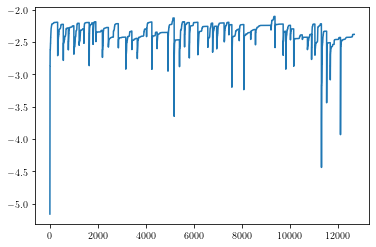

In [10]:
fig, ax = plt.subplots()
ax.plot( np.linspace(1, len(beta_C), len(beta_C)), np.array(beta_C) )
# ax.set_ylim((-5, -1.9));

In [8]:
res

                        fun: 2.0458644344747055
 lowest_optimization_result:  final_simplex: (array([[1.63832257, 3.18675841, 2.35648873, 0.81601812, 0.84368379],
       [1.6383093 , 3.18671161, 2.35645642, 0.81597984, 0.84367956],
       [1.6383138 , 3.18678915, 2.35651641, 0.81605626, 0.8436918 ],
       [1.63826238, 3.18679343, 2.35650551, 0.81606112, 0.84370012],
       [1.63834529, 3.18676816, 2.3565382 , 0.81603508, 0.84370343],
       [1.63829678, 3.1867649 , 2.35652618, 0.81603408, 0.84370533]]), array([2.04586443, 2.04587681, 2.04588118, 2.04589089, 2.04589334,
       2.04589781]))
           fun: 2.0458644344747055
       message: 'Optimization terminated successfully.'
          nfev: 294
           nit: 180
        status: 0
       success: True
             x: array([1.63832257, 3.18675841, 2.35648873, 0.81601812, 0.84368379])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                 

In [20]:
Bell_terms

[array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 array([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]]),
 array([[ 1.000000e+00,  6.123234e-17,  0.000000e+00,  0.000000e+00],
        [ 6.123234e-17, -1.000000e+00,  0.000000e+00, -0.000000e+00],
        [ 0.000000e+00,  0.000000e+00,  1.000000e+00,  6.123234e-17],
        [ 0.000000e+00, -0.000000e+00,  6.123234e-17, -1.000000e+00]]),
 array([[0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.]]),
 array([[0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.]]),
 array([[ 0.000000e+00,  0.000000e+00,  1.000000e+00,  6.123234e-17],
        [ 0.000000e+00, -0.000000e+00,  6.123234e-17, -1.000000e+00],
        [ 1.000000e+00,  6.123234e-17,  0.000000e+00,  0.000000e+00],
        [ 6.123234e-17, -1.000000e+00,  0.000000e+00, -0.000000e+00]]),
 array([[ 1.